In [1]:
import utils.data_import as data_import
import utils.ml_utils as ml_utils

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchtext import data, vocab

import os, sys
import pdb
import pandas as pd
import numpy as np
import math
from tqdm import tnrange, tqdm_notebook
#from tqdm.autonotebook import tqdm

import importlib

import settings

np.random.seed(123)

In [2]:
cuda = torch.cuda.is_available()
if cuda:
    print('Cuda is available!')
    print('Device:', torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print('No cuda.')
    
import matplotlib.pyplot as plt
%matplotlib inline

Cuda is available!
Device: Tesla V100-SXM2-16GB


In [3]:
corpus = data_import.Corpus(file_path=settings.wikitext_path, lines=settings.lines)    
corpus.batchify(batch_size=settings.batch_size, seq_length=settings.window_size)

Generated train: 2,370,351 tokens (36,717 lines)
Generated valid: 245,498 tokens (3,759 lines)
Generated test:  273,186 tokens (4,357 lines)
Generated vocab: 28,913
Generated oov:   2.8%
Batchifying train... Done.  torch.Size([29629, 80])
Batchifying valid... Done.  torch.Size([3068, 80])
Batchifying test...  Done.  torch.Size([3414, 80])


In [4]:
corpus.train.show_itoklist(29629,29629+70)

3 3866 3 1624 869 346 3519 305 14 160 1894 149 10 62 1197 1791 278 1199 2685 23 2233 346 2186 44 3 3890 566 36 4186 93 3874 3875 62 16 1 3 44 2235 38 46 14 3 3850 902 44 18 3 850 848 3 4187 3 2080 127 62 3 671 127 2 3 4188 3 1668 62 563 14 4189 4190 16 3 

In [5]:
corpus.train.batch_matrix[:70,1]

tensor([   3, 3866,    3, 1624,  869,  346, 3519,  305,   14,  160, 1894,  149,
          10,   62, 1197, 1791,  278, 1199, 2685,   23, 2233,  346, 2186,   44,
           3, 3890,  566,   36, 4186,   93, 3874, 3875,   62,   16,    1,    3,
          44, 2235,   38,   46,   14,    3, 3850,  902,   44,   18,    3,  850,
         848,    3, 4187,    3, 2080,  127,   62,    3,  671,  127,    2,    3,
        4188,    3, 1668,   62,  563,   14, 4189, 4190,   16,    3])

count    441.000000
mean      67.183673
std        9.157476
min       27.000000
25%       65.000000
50%       69.000000
75%       72.000000
max       84.000000
Name: len, dtype: float64


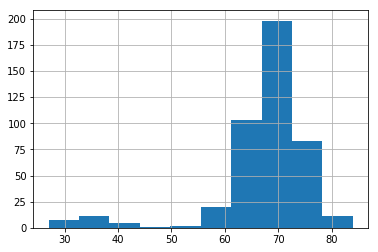

In [6]:
df = corpus.train.batch_stats()
df.hist()

In [7]:
train_dl = data_import.WikiTextDataset(corpus.train)
valid_dl = data_import.WikiTextDataset(corpus.valid)
test_dl = data_import.WikiTextDataset(corpus.test)

In [8]:
print(len(corpus.vocab))

28913


In [9]:
class simpleLSTM(nn.Module):
    def __init__(self, emb_dim, hidden_dim, n_layers=1,
                 dropout=0, bidirectional=True):
        super().__init__()
        
        self.hidden_dim = hidden_dim
        self.ndir = (2 if bidirectional==True else 1)
        
        self.embedding = nn.Embedding(len(corpus.vocab), emb_dim)
        
        self.lstm = nn.LSTM(emb_dim, hidden_dim, num_layers=n_layers,
                            bidirectional=bidirectional, dropout=dropout)
        
        self.fc = nn.Linear(self.ndir*hidden_dim, len(corpus.vocab))
        
        self.dropout = nn.Dropout(dropout)
        
        self.init_weights()
        
    def init_weights(self, initrange=0.1):
        
        self.embedding.weight.data.uniform_(-initrange, initrange) 
        
        for name, param in self.lstm.named_parameters():
            if 'bias' in name:
                param.data.zero_()
            elif 'weight' in name:
                param.data.uniform_(-initrange, initrange)

        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()
        
    def forward(self, seq):
        
        #pdb.set_trace()
        # seq dims: [seq len, batch size]
        
        emb = self.embedding(seq)
        # emb dims: [seq len, batch size, emb dim]
        
        out, (hid, cel) = self.lstm(emb)
        
        # out dims: [seq len, batch size, hidden_dim]
        # hid dims: [2*n_layers, batch size, hidden_dim]
        # cel dims: [2*n_layers, batch size, hidden_dim]
        # out[-1,:,:hd] -> [batch size, hidden_dim]  (last time step hidden vector)
        # out[0,:,hd:] <- [batch size, hidden_dim]  (first time step hidden vector)
        # contatenation of last time period, whole batch, forward (first) chunck of hidden units
        #   and the first time period, whole batch, backward (last) chunck of hidden units
        #   (pytorch concatenates hidden units across dim #2 for bidirectional LSTM)
        #if self.ndir == 2:
        #    conc = torch.cat((out[-1,:,:self.hidden_dim], out[0,:,self.hidden_dim:]), dim=1)
        #else:
        #    conc = out[0,:,self.hidden_dim]
        
        output = self.dropout(out)
        
        output = self.fc(output)
        
        # sm dims: [batch size, n_classes]
        #sm = F.log_softmax(output, dim=-1)
        #return sm
    
        return output

In [10]:
model = simpleLSTM(emb_dim=settings.emb_dim,
                   hidden_dim=settings.hidden_dim,
                   n_layers=settings.num_layers,
                   dropout=settings.dropout
                  )

In [11]:
if cuda:
    model = model.cuda()

In [12]:
print(model)

simpleLSTM(
  (embedding): Embedding(28913, 400)
  (lstm): LSTM(400, 1150, num_layers=2, dropout=0.4, bidirectional=True)
  (fc): Linear(in_features=2300, out_features=28913, bias=True)
  (dropout): Dropout(p=0.4)
)


In [13]:
missclass = []
missclass_next = []
losses = []

In [14]:
from tqdm import tqdm
def run_epochs(model, train_dl, valid_dl, epochs=settings.epochs,
               losses=[], missclass=[]):
    
    opt = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-6)
    #opt = optim.Adam(model.parameters(), lr=0.001)
    #loss_func = nn.NLLLoss()
    loss_func = nn.CrossEntropyLoss()
    
    scheduler = optim.lr_scheduler.StepLR(opt, step_size=20, gamma=0.8)
    
    try: # Allow for user interrupt
 
        for epoch in range(1, epochs + 1):
            scheduler.step()
            running_loss = 0.0
            running_corrects = 0
            model.train() # turn on training mode

            num_vals = 0
            num_correct = 0
            miss_next_wd = 0
            next_wd_tot = 0

            #pdb.set_trace()

            for x, y in tqdm_notebook(train_dl, desc='Train {}/{}'.format(epoch, epochs)):
                opt.zero_grad()
                
                if cuda:
                    x = x.cuda()
                    y = y.cuda()

                preds = model(x)
                loss = loss_func(preds.view(-1, preds.size(2)), y.view(-1).long())

                loss.backward()
                #torch.nn.utils.clip_grad_norm_(model.parameters(), 0.25)
                opt.step()

                running_loss += loss.item() * x.size(0) / x.size(1)

                _, y_preds = torch.max(preds, dim=2)
                num_correct += torch.sum(y == y_preds).item()
                num_vals += y.size(0)*y.size(1)
                
                miss_next_wd += ml_utils.calc_miss_next_wds(y, y_preds)
                next_wd_tot += y.size(1)

            #pdb.set_trace()

            missclass_tr = 1 - num_correct / num_vals
            miss_next_wd_rate_tr = miss_next_wd / next_wd_tot

            epoch_loss = running_loss / len(train_dl)

            num_vals = 0
            num_correct = 0
            miss_next_wd = 0
            next_wd_tot = 0

            # calculate the validation loss for this epoch
            val_loss = 0.0
            model.eval() # turn on evaluation mode
            
            with torch.no_grad():
                for x, y in tqdm_notebook(valid_dl, desc='Valid {}/{}'.format(epoch, epochs)):
                    if cuda:
                        x = x.cuda()
                        y = y.cuda()   
                        
                    preds = model(x)
                    loss = loss_func(preds.view(-1, preds.size(2)), y.view(-1).long())

                    val_loss += loss.item() * x.size(0) / x.size(1)

                    _, y_preds = torch.max(preds, dim=2)
                    num_correct += torch.sum(y == y_preds).item()
                    num_vals += y.size(0)*y.size(1)
                    
                    miss_next_wd += ml_utils.calc_miss_next_wds(y, y_preds)
                    next_wd_tot += y.size(1)

            #pdb.set_trace()

            missclass_te = 1 - num_correct / num_vals
            val_loss /= len(valid_dl)
            
            miss_next_wd_rate_val = miss_next_wd / next_wd_tot
            
            missclass_next.append((miss_next_wd_rate_tr, miss_next_wd_rate_val))
            missclass.append((missclass_tr, missclass_te))
            losses.append((epoch_loss, val_loss))

            print('Epoch: {}/{}, Loss: [{:.4f}, {:.4f}], Ppl: [{:6.2f}, {:6.2f}], Miss: [{:.2%}, {:.2%}], [{:.2%}, {:.2%}]'\
                  .format(epoch, epochs, epoch_loss, val_loss, 
                          math.exp(epoch_loss), math.exp(val_loss), 
                          missclass_tr, missclass_te,
                          miss_next_wd_rate_tr, miss_next_wd_rate_val))
            sys.stdout.flush()

            print('Saving weights file...', end=' ', flush=True)
            torch.save(model, 'model_weights.pt')
            print('Done.', flush=True)
            #to load: model = torch.load('model_weights.pt')
            
    except KeyboardInterrupt:
        print('Stopping with latest weights.')
        
    return model, opt, losses, missclass

In [15]:
model, opt, losses, missclass = run_epochs(model, train_dl, valid_dl, epochs=settings.epochs,
                                           losses=losses, missclass=missclass)


Epoch: 1/200, Loss: [7.9247, 6.9190], Ppl: [2764.81, 1011.32], Miss: [90.25%, 87.42%], [94.17%, 93.35%]
Saving weights file... 

/r/ge.unx.sas.com/vol/vol620/u62/ivoliv/.conda/envs/ONE/lib/python3.7/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type simpleLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Done.



Epoch: 2/200, Loss: [6.5271, 5.5069], Ppl: [683.39, 246.39], Miss: [86.92%, 87.40%], [93.46%, 93.35%]
Saving weights file... Done.



Epoch: 3/200, Loss: [5.7461, 4.0157], Ppl: [312.97,  55.46], Miss: [84.46%, 60.84%], [90.17%, 56.36%]
Saving weights file... Done.



Epoch: 4/200, Loss: [3.6453, 2.4747], Ppl: [ 38.29,  11.88], Miss: [51.90%, 39.05%], [56.77%, 52.23%]
Saving weights file... Done.



Epoch: 5/200, Loss: [2.5830, 1.7463], Ppl: [ 13.24,   5.73], Miss: [39.63%, 28.41%], [54.04%, 51.46%]
Saving weights file... Done.



Epoch: 6/200, Loss: [2.0101, 1.2369], Ppl: [  7.46,   3.44], Miss: [31.94%, 21.05%], [53.57%, 51.17%]
Saving weights file... Done.



Epoch: 7/200, Loss: [1.6461, 1.0876], Ppl: [  5.19,   2.97], Miss: [26.98%, 18.02%], [53.05%, 51.44%]
Saving weights file... Done.



Epoch: 8/200, Loss: [1.5407, 0.7373], Ppl: [  4.67,   2.09], Miss: [24.60%, 13.52%], [52.85%, 51.68%]
Saving weights file... Done.



Epoch: 9/200, Loss: [1.1654, 0.5932], Ppl: [  3.21,   1.81], Miss: [20.23%, 11.20%], [52.22%, 50.43%]
Saving weights file... Done.



Epoch: 10/200, Loss: [0.9135, 0.5034], Ppl: [  2.49,   1.65], Miss: [16.68%, 9.46%], [51.27%, 50.24%]
Saving weights file... Done.



Epoch: 11/200, Loss: [0.7289, 0.3980], Ppl: [  2.07,   1.49], Miss: [13.82%, 7.61%], [50.87%, 50.19%]
Saving weights file... Done.



Epoch: 12/200, Loss: [0.6384, 0.3398], Ppl: [  1.89,   1.40], Miss: [12.32%, 6.43%], [50.55%, 49.92%]
Saving weights file... Done.



Epoch: 13/200, Loss: [0.5480, 0.3320], Ppl: [  1.73,   1.39], Miss: [10.79%, 6.38%], [50.23%, 49.92%]
Saving weights file... Done.



Epoch: 14/200, Loss: [0.5048, 0.2866], Ppl: [  1.66,   1.33], Miss: [10.09%, 5.56%], [50.35%, 50.16%]
Saving weights file... Done.



Epoch: 15/200, Loss: [0.4373, 0.2439], Ppl: [  1.55,   1.28], Miss: [8.82%, 4.83%], [50.00%, 49.76%]
Saving weights file... Done.



Epoch: 16/200, Loss: [0.3761, 0.2253], Ppl: [  1.46,   1.25], Miss: [7.69%, 4.33%], [49.54%, 49.28%]
Saving weights file... Done.



Epoch: 17/200, Loss: [0.3283, 0.1996], Ppl: [  1.39,   1.22], Miss: [6.76%, 3.88%], [49.58%, 49.68%]
Saving weights file... Done.



Epoch: 18/200, Loss: [0.3140, 0.1913], Ppl: [  1.37,   1.21], Miss: [6.56%, 3.85%], [49.82%, 49.47%]
Saving weights file... Done.



Epoch: 19/200, Loss: [0.2735, 0.1712], Ppl: [  1.31,   1.19], Miss: [5.71%, 3.32%], [49.34%, 49.84%]
Saving weights file... Done.



Epoch: 20/200, Loss: [0.2416, 0.1614], Ppl: [  1.27,   1.18], Miss: [5.03%, 3.21%], [49.19%, 50.40%]
Saving weights file... Done.



Epoch: 21/200, Loss: [0.1948, 0.1297], Ppl: [  1.22,   1.14], Miss: [3.96%, 2.53%], [48.69%, 49.60%]
Saving weights file... Done.



Epoch: 22/200, Loss: [0.1807, 0.1289], Ppl: [  1.20,   1.14], Miss: [3.66%, 2.51%], [48.52%, 48.62%]
Saving weights file... Done.



Epoch: 23/200, Loss: [0.1718, 0.1304], Ppl: [  1.19,   1.14], Miss: [3.48%, 2.50%], [47.96%, 48.91%]
Saving weights file... Done.



Epoch: 24/200, Loss: [0.1661, 0.1206], Ppl: [  1.18,   1.13], Miss: [3.39%, 2.33%], [47.89%, 48.86%]
Saving weights file... Done.



Epoch: 25/200, Loss: [0.1625, 0.1146], Ppl: [  1.18,   1.12], Miss: [3.34%, 2.18%], [47.41%, 48.99%]
Saving weights file... Done.



Epoch: 26/200, Loss: [0.1543, 0.1087], Ppl: [  1.17,   1.11], Miss: [3.16%, 2.02%], [47.23%, 48.67%]
Saving weights file... Done.



Epoch: 27/200, Loss: [0.1418, 0.1094], Ppl: [  1.15,   1.12], Miss: [2.83%, 2.05%], [46.72%, 48.22%]
Saving weights file... Done.



Epoch: 28/200, Loss: [0.1389, 0.1086], Ppl: [  1.15,   1.11], Miss: [2.77%, 2.05%], [45.97%, 48.35%]
Saving weights file... Done.



Epoch: 29/200, Loss: [0.1370, 0.1057], Ppl: [  1.15,   1.11], Miss: [2.75%, 1.93%], [45.74%, 48.30%]
Saving weights file... Done.



Epoch: 30/200, Loss: [0.1296, 0.1027], Ppl: [  1.14,   1.11], Miss: [2.54%, 1.86%], [45.05%, 49.04%]
Saving weights file... Done.



Epoch: 31/200, Loss: [0.1248, 0.1017], Ppl: [  1.13,   1.11], Miss: [2.43%, 1.78%], [44.62%, 48.38%]
Saving weights file... Done.



Epoch: 32/200, Loss: [0.1235, 0.1036], Ppl: [  1.13,   1.11], Miss: [2.40%, 1.85%], [44.37%, 48.59%]
Saving weights file... Done.



Epoch: 33/200, Loss: [0.1196, 0.0992], Ppl: [  1.13,   1.10], Miss: [2.32%, 1.69%], [44.12%, 48.54%]
Saving weights file... Done.



Epoch: 34/200, Loss: [0.1172, 0.0957], Ppl: [  1.12,   1.10], Miss: [2.23%, 1.59%], [43.68%, 48.75%]
Saving weights file... Done.



Epoch: 35/200, Loss: [0.1130, 0.0982], Ppl: [  1.12,   1.10], Miss: [2.12%, 1.63%], [43.36%, 49.02%]
Saving weights file... Done.



Epoch: 36/200, Loss: [0.1232, 0.0965], Ppl: [  1.13,   1.10], Miss: [2.46%, 1.62%], [43.44%, 49.23%]
Saving weights file... Done.



Epoch: 37/200, Loss: [0.1074, 0.0968], Ppl: [  1.11,   1.10], Miss: [2.00%, 1.57%], [43.07%, 48.96%]
Saving weights file... Done.



Epoch: 38/200, Loss: [0.1066, 0.0915], Ppl: [  1.11,   1.10], Miss: [1.98%, 1.50%], [42.69%, 48.67%]
Saving weights file... Done.



Epoch: 39/200, Loss: [0.1113, 0.0937], Ppl: [  1.12,   1.10], Miss: [2.14%, 1.51%], [42.56%, 48.83%]
Saving weights file... Done.



Epoch: 40/200, Loss: [0.1064, 0.0932], Ppl: [  1.11,   1.10], Miss: [2.00%, 1.50%], [42.76%, 48.96%]
Saving weights file... Done.



Epoch: 41/200, Loss: [0.0900, 0.0876], Ppl: [  1.09,   1.09], Miss: [1.53%, 1.36%], [41.63%, 48.75%]
Saving weights file... Done.



Epoch: 42/200, Loss: [0.0886, 0.0910], Ppl: [  1.09,   1.10], Miss: [1.46%, 1.41%], [40.94%, 48.88%]
Saving weights file... Done.



Epoch: 43/200, Loss: [0.0906, 0.0906], Ppl: [  1.09,   1.09], Miss: [1.52%, 1.42%], [40.80%, 48.35%]
Saving weights file... Done.



Epoch: 44/200, Loss: [0.0924, 0.0908], Ppl: [  1.10,   1.10], Miss: [1.58%, 1.39%], [40.89%, 48.46%]
Saving weights file... Done.



Epoch: 45/200, Loss: [0.0915, 0.0909], Ppl: [  1.10,   1.10], Miss: [1.57%, 1.38%], [40.75%, 48.80%]
Saving weights file... Done.



Epoch: 46/200, Loss: [0.0917, 0.0920], Ppl: [  1.10,   1.10], Miss: [1.59%, 1.39%], [40.72%, 48.99%]
Saving weights file... Done.



Epoch: 47/200, Loss: [0.0905, 0.0901], Ppl: [  1.09,   1.09], Miss: [1.56%, 1.36%], [40.35%, 48.80%]
Saving weights file... Done.



Epoch: 48/200, Loss: [0.0903, 0.0898], Ppl: [  1.09,   1.09], Miss: [1.55%, 1.37%], [40.29%, 48.62%]
Saving weights file... Done.



Epoch: 49/200, Loss: [0.0875, 0.0905], Ppl: [  1.09,   1.09], Miss: [1.49%, 1.34%], [40.06%, 48.40%]
Saving weights file... Done.



Epoch: 50/200, Loss: [0.0894, 0.0927], Ppl: [  1.09,   1.10], Miss: [1.55%, 1.44%], [39.95%, 48.99%]
Saving weights file... Done.



Epoch: 51/200, Loss: [0.0875, 0.0936], Ppl: [  1.09,   1.10], Miss: [1.49%, 1.43%], [39.71%, 49.65%]
Saving weights file... Done.



Epoch: 52/200, Loss: [0.0854, 0.0929], Ppl: [  1.09,   1.10], Miss: [1.44%, 1.42%], [39.51%, 48.88%]
Saving weights file... Done.



Epoch: 53/200, Loss: [0.0868, 0.0928], Ppl: [  1.09,   1.10], Miss: [1.48%, 1.38%], [39.30%, 48.86%]
Saving weights file... Done.



Epoch: 54/200, Loss: [0.0859, 0.0918], Ppl: [  1.09,   1.10], Miss: [1.46%, 1.37%], [39.14%, 48.72%]
Saving weights file... Done.



Epoch: 55/200, Loss: [0.0857, 0.0929], Ppl: [  1.09,   1.10], Miss: [1.46%, 1.38%], [39.25%, 49.10%]
Saving weights file... Done.



Epoch: 56/200, Loss: [0.0847, 0.0938], Ppl: [  1.09,   1.10], Miss: [1.44%, 1.44%], [39.04%, 49.36%]
Saving weights file... Done.



Epoch: 57/200, Loss: [0.0841, 0.0925], Ppl: [  1.09,   1.10], Miss: [1.43%, 1.41%], [39.02%, 49.84%]
Saving weights file... Done.



Epoch: 58/200, Loss: [0.0846, 0.0923], Ppl: [  1.09,   1.10], Miss: [1.44%, 1.36%], [38.66%, 48.35%]
Saving weights file... Done.



Epoch: 59/200, Loss: [0.0833, 0.0924], Ppl: [  1.09,   1.10], Miss: [1.41%, 1.36%], [38.84%, 49.12%]
Saving weights file... Done.



Epoch: 60/200, Loss: [0.0826, 0.0928], Ppl: [  1.09,   1.10], Miss: [1.40%, 1.40%], [38.68%, 49.55%]
Saving weights file... Done.



Epoch: 61/200, Loss: [0.0741, 0.0907], Ppl: [  1.08,   1.09], Miss: [1.19%, 1.31%], [37.83%, 49.57%]
Saving weights file... Done.



Epoch: 62/200, Loss: [0.0720, 0.0931], Ppl: [  1.07,   1.10], Miss: [1.11%, 1.36%], [36.86%, 49.63%]
Saving weights file... Done.



Epoch: 63/200, Loss: [0.0734, 0.0938], Ppl: [  1.08,   1.10], Miss: [1.15%, 1.35%], [37.03%, 49.84%]
Saving weights file... Done.



Epoch: 64/200, Loss: [0.0738, 0.0923], Ppl: [  1.08,   1.10], Miss: [1.17%, 1.33%], [36.76%, 49.63%]
Saving weights file... Done.



Epoch: 65/200, Loss: [0.0737, 0.0937], Ppl: [  1.08,   1.10], Miss: [1.17%, 1.33%], [36.50%, 49.49%]
Saving weights file... Done.



Epoch: 66/200, Loss: [0.0744, 0.0949], Ppl: [  1.08,   1.10], Miss: [1.19%, 1.38%], [36.74%, 49.60%]
Saving weights file... Done.



Epoch: 67/200, Loss: [0.0742, 0.0929], Ppl: [  1.08,   1.10], Miss: [1.19%, 1.36%], [36.81%, 49.07%]
Saving weights file... Done.



Epoch: 68/200, Loss: [0.0728, 0.0948], Ppl: [  1.08,   1.10], Miss: [1.16%, 1.35%], [36.38%, 49.73%]
Saving weights file... Done.



Epoch: 69/200, Loss: [0.0736, 0.0944], Ppl: [  1.08,   1.10], Miss: [1.19%, 1.34%], [36.22%, 49.44%]
Saving weights file... Done.



Epoch: 70/200, Loss: [0.0726, 0.0942], Ppl: [  1.08,   1.10], Miss: [1.16%, 1.34%], [36.40%, 49.55%]
Saving weights file... Done.



Epoch: 71/200, Loss: [0.0719, 0.0941], Ppl: [  1.07,   1.10], Miss: [1.15%, 1.36%], [36.33%, 49.71%]
Saving weights file... Done.



Epoch: 72/200, Loss: [0.0711, 0.0940], Ppl: [  1.07,   1.10], Miss: [1.14%, 1.33%], [36.16%, 49.28%]
Saving weights file... Done.



Epoch: 73/200, Loss: [0.0724, 0.0956], Ppl: [  1.08,   1.10], Miss: [1.17%, 1.34%], [36.07%, 49.71%]
Saving weights file... Done.



Epoch: 74/200, Loss: [0.0699, 0.0957], Ppl: [  1.07,   1.10], Miss: [1.12%, 1.36%], [35.73%, 50.03%]
Saving weights file... Done.



Epoch: 75/200, Loss: [0.0714, 0.0956], Ppl: [  1.07,   1.10], Miss: [1.15%, 1.36%], [35.65%, 49.31%]
Saving weights file... Done.



Epoch: 76/200, Loss: [0.0704, 0.0950], Ppl: [  1.07,   1.10], Miss: [1.14%, 1.35%], [35.50%, 49.87%]
Saving weights file... Done.



Epoch: 77/200, Loss: [0.0695, 0.0961], Ppl: [  1.07,   1.10], Miss: [1.12%, 1.34%], [35.32%, 49.79%]
Saving weights file... Done.



Epoch: 78/200, Loss: [0.0692, 0.0972], Ppl: [  1.07,   1.10], Miss: [1.11%, 1.33%], [35.35%, 49.63%]
Saving weights file... Done.



Epoch: 79/200, Loss: [0.0693, 0.0988], Ppl: [  1.07,   1.10], Miss: [1.12%, 1.37%], [35.27%, 50.24%]
Saving weights file... Done.



Epoch: 80/200, Loss: [0.0688, 0.0979], Ppl: [  1.07,   1.10], Miss: [1.11%, 1.36%], [35.13%, 50.35%]
Saving weights file... Done.



Epoch: 81/200, Loss: [0.0620, 0.0952], Ppl: [  1.06,   1.10], Miss: [0.97%, 1.32%], [33.85%, 50.13%]
Saving weights file... Done.



Epoch: 82/200, Loss: [0.0612, 0.0982], Ppl: [  1.06,   1.10], Miss: [0.94%, 1.34%], [33.36%, 50.80%]
Saving weights file... Done.



Epoch: 83/200, Loss: [0.0614, 0.0983], Ppl: [  1.06,   1.10], Miss: [0.95%, 1.34%], [33.33%, 50.48%]
Saving weights file... Done.



Epoch: 84/200, Loss: [0.0614, 0.0978], Ppl: [  1.06,   1.10], Miss: [0.95%, 1.32%], [33.10%, 50.16%]
Saving weights file... Done.



Epoch: 85/200, Loss: [0.0625, 0.1001], Ppl: [  1.06,   1.11], Miss: [0.97%, 1.36%], [32.97%, 50.69%]
Saving weights file... Done.



Epoch: 86/200, Loss: [0.0618, 0.1007], Ppl: [  1.06,   1.11], Miss: [0.96%, 1.34%], [32.89%, 50.61%]
Saving weights file... Done.



Epoch: 87/200, Loss: [0.0613, 0.1014], Ppl: [  1.06,   1.11], Miss: [0.95%, 1.35%], [32.78%, 50.37%]
Saving weights file... Done.



Epoch: 88/200, Loss: [0.0608, 0.1019], Ppl: [  1.06,   1.11], Miss: [0.94%, 1.34%], [32.64%, 50.43%]
Saving weights file... Done.



Epoch: 89/200, Loss: [0.0608, 0.1010], Ppl: [  1.06,   1.11], Miss: [0.95%, 1.36%], [32.64%, 51.06%]
Saving weights file... Done.



Epoch: 90/200, Loss: [0.0606, 0.1027], Ppl: [  1.06,   1.11], Miss: [0.95%, 1.35%], [32.23%, 51.25%]
Saving weights file... Done.



Epoch: 91/200, Loss: [0.0601, 0.1020], Ppl: [  1.06,   1.11], Miss: [0.94%, 1.36%], [32.05%, 51.49%]
Saving weights file... Done.



Epoch: 92/200, Loss: [0.0596, 0.1028], Ppl: [  1.06,   1.11], Miss: [0.94%, 1.38%], [32.19%, 51.60%]
Saving weights file... Done.



Epoch: 93/200, Loss: [0.0596, 0.1045], Ppl: [  1.06,   1.11], Miss: [0.93%, 1.37%], [31.96%, 51.41%]
Saving weights file... Done.



Epoch: 94/200, Loss: [0.0587, 0.1053], Ppl: [  1.06,   1.11], Miss: [0.92%, 1.36%], [31.53%, 51.54%]
Saving weights file... Done.



Epoch: 95/200, Loss: [0.0586, 0.1051], Ppl: [  1.06,   1.11], Miss: [0.92%, 1.36%], [31.56%, 51.14%]
Saving weights file... Done.



Epoch: 96/200, Loss: [0.0581, 0.1034], Ppl: [  1.06,   1.11], Miss: [0.91%, 1.35%], [31.59%, 51.09%]
Saving weights file... Done.



Epoch: 97/200, Loss: [0.0581, 0.1057], Ppl: [  1.06,   1.11], Miss: [0.91%, 1.35%], [31.12%, 51.04%]
Saving weights file... Done.



Epoch: 98/200, Loss: [0.0580, 0.1073], Ppl: [  1.06,   1.11], Miss: [0.91%, 1.36%], [31.30%, 51.25%]
Saving weights file... Done.



Epoch: 99/200, Loss: [0.0574, 0.1057], Ppl: [  1.06,   1.11], Miss: [0.90%, 1.36%], [31.05%, 51.01%]
Saving weights file... Done.



Epoch: 100/200, Loss: [0.0575, 0.1072], Ppl: [  1.06,   1.11], Miss: [0.90%, 1.36%], [31.03%, 50.59%]
Saving weights file... Done.



Epoch: 101/200, Loss: [0.0519, 0.1072], Ppl: [  1.05,   1.11], Miss: [0.81%, 1.34%], [29.67%, 50.56%]
Saving weights file... Done.



Epoch: 102/200, Loss: [0.0509, 0.1092], Ppl: [  1.05,   1.12], Miss: [0.78%, 1.35%], [28.87%, 51.17%]
Saving weights file... Done.



Epoch: 103/200, Loss: [0.0510, 0.1091], Ppl: [  1.05,   1.12], Miss: [0.79%, 1.37%], [28.97%, 51.73%]
Saving weights file... Done.



Epoch: 104/200, Loss: [0.0512, 0.1094], Ppl: [  1.05,   1.12], Miss: [0.79%, 1.36%], [28.71%, 50.96%]
Saving weights file... Done.



Epoch: 105/200, Loss: [0.0509, 0.1101], Ppl: [  1.05,   1.12], Miss: [0.79%, 1.36%], [28.72%, 51.14%]
Saving weights file... Done.



Epoch: 106/200, Loss: [0.0511, 0.1101], Ppl: [  1.05,   1.12], Miss: [0.79%, 1.36%], [28.59%, 51.17%]
Saving weights file... Done.



Epoch: 107/200, Loss: [0.0502, 0.1094], Ppl: [  1.05,   1.12], Miss: [0.78%, 1.35%], [28.37%, 50.96%]
Saving weights file... Done.



Epoch: 108/200, Loss: [0.0506, 0.1103], Ppl: [  1.05,   1.12], Miss: [0.79%, 1.35%], [28.22%, 50.88%]
Saving weights file... Done.



Epoch: 109/200, Loss: [0.0503, 0.1113], Ppl: [  1.05,   1.12], Miss: [0.79%, 1.36%], [28.22%, 51.65%]
Saving weights file... Done.



Epoch: 110/200, Loss: [0.0498, 0.1124], Ppl: [  1.05,   1.12], Miss: [0.78%, 1.35%], [28.17%, 50.93%]
Saving weights file... Done.



Epoch: 111/200, Loss: [0.0491, 0.1126], Ppl: [  1.05,   1.12], Miss: [0.77%, 1.37%], [27.78%, 51.70%]
Saving weights file... Done.



Epoch: 112/200, Loss: [0.0489, 0.1125], Ppl: [  1.05,   1.12], Miss: [0.77%, 1.37%], [28.01%, 51.73%]
Saving weights file... Done.



Epoch: 113/200, Loss: [0.0488, 0.1131], Ppl: [  1.05,   1.12], Miss: [0.77%, 1.35%], [27.91%, 50.85%]
Saving weights file... Done.



Epoch: 114/200, Loss: [0.0480, 0.1154], Ppl: [  1.05,   1.12], Miss: [0.76%, 1.37%], [27.59%, 51.65%]
Saving weights file... Done.



Epoch: 115/200, Loss: [0.0482, 0.1147], Ppl: [  1.05,   1.12], Miss: [0.77%, 1.37%], [27.78%, 51.62%]
Saving weights file... Done.



Epoch: 116/200, Loss: [0.0476, 0.1183], Ppl: [  1.05,   1.13], Miss: [0.76%, 1.38%], [27.40%, 51.91%]
Saving weights file... Done.



Epoch: 117/200, Loss: [0.0470, 0.1168], Ppl: [  1.05,   1.12], Miss: [0.75%, 1.36%], [27.04%, 51.76%]
Saving weights file... Done.



Epoch: 118/200, Loss: [0.0470, 0.1153], Ppl: [  1.05,   1.12], Miss: [0.75%, 1.36%], [27.16%, 51.54%]
Saving weights file... Done.



Epoch: 119/200, Loss: [0.0467, 0.1158], Ppl: [  1.05,   1.12], Miss: [0.74%, 1.37%], [26.85%, 51.46%]
Saving weights file... Done.



Epoch: 120/200, Loss: [0.0467, 0.1163], Ppl: [  1.05,   1.12], Miss: [0.75%, 1.34%], [27.11%, 50.72%]
Saving weights file... Done.



Epoch: 121/200, Loss: [0.0427, 0.1159], Ppl: [  1.04,   1.12], Miss: [0.69%, 1.36%], [25.86%, 51.54%]
Saving weights file... Done.



Epoch: 122/200, Loss: [0.0409, 0.1194], Ppl: [  1.04,   1.13], Miss: [0.65%, 1.36%], [24.65%, 51.54%]
Saving weights file... Done.



Epoch: 123/200, Loss: [0.0412, 0.1209], Ppl: [  1.04,   1.13], Miss: [0.65%, 1.36%], [24.34%, 51.41%]
Saving weights file... Done.



Epoch: 124/200, Loss: [0.0409, 0.1187], Ppl: [  1.04,   1.13], Miss: [0.66%, 1.35%], [24.65%, 50.98%]
Saving weights file... Done.



Epoch: 125/200, Loss: [0.0408, 0.1187], Ppl: [  1.04,   1.13], Miss: [0.65%, 1.36%], [24.48%, 51.06%]
Saving weights file... Done.



Epoch: 126/200, Loss: [0.0406, 0.1212], Ppl: [  1.04,   1.13], Miss: [0.65%, 1.38%], [24.28%, 52.05%]
Saving weights file... Done.



Epoch: 127/200, Loss: [0.0405, 0.1222], Ppl: [  1.04,   1.13], Miss: [0.65%, 1.36%], [24.33%, 51.41%]
Saving weights file... Done.



Epoch: 128/200, Loss: [0.0402, 0.1217], Ppl: [  1.04,   1.13], Miss: [0.65%, 1.36%], [24.06%, 51.52%]
Saving weights file... Done.



Epoch: 129/200, Loss: [0.0396, 0.1242], Ppl: [  1.04,   1.13], Miss: [0.63%, 1.38%], [23.73%, 52.13%]
Saving weights file... Done.



Epoch: 130/200, Loss: [0.0394, 0.1257], Ppl: [  1.04,   1.13], Miss: [0.63%, 1.38%], [23.67%, 51.99%]
Saving weights file... Done.



Epoch: 131/200, Loss: [0.0388, 0.1245], Ppl: [  1.04,   1.13], Miss: [0.63%, 1.37%], [23.29%, 51.99%]
Saving weights file... Done.



Epoch: 132/200, Loss: [0.0392, 0.1253], Ppl: [  1.04,   1.13], Miss: [0.63%, 1.37%], [23.42%, 51.36%]
Saving weights file... Done.



Epoch: 133/200, Loss: [0.0383, 0.1262], Ppl: [  1.04,   1.13], Miss: [0.62%, 1.38%], [23.21%, 52.07%]
Saving weights file... Done.



Epoch: 134/200, Loss: [0.0377, 0.1270], Ppl: [  1.04,   1.14], Miss: [0.61%, 1.38%], [22.92%, 51.81%]
Saving weights file... Done.



Epoch: 135/200, Loss: [0.0374, 0.1275], Ppl: [  1.04,   1.14], Miss: [0.61%, 1.37%], [22.72%, 51.94%]
Saving weights file... Done.



Epoch: 136/200, Loss: [0.0374, 0.1258], Ppl: [  1.04,   1.13], Miss: [0.61%, 1.37%], [22.93%, 51.91%]
Saving weights file... Done.



Epoch: 137/200, Loss: [0.0369, 0.1265], Ppl: [  1.04,   1.13], Miss: [0.60%, 1.37%], [22.48%, 51.86%]
Saving weights file... Done.



Epoch: 138/200, Loss: [0.0368, 0.1269], Ppl: [  1.04,   1.14], Miss: [0.60%, 1.38%], [22.27%, 52.07%]
Saving weights file... Done.



Epoch: 139/200, Loss: [0.0359, 0.1275], Ppl: [  1.04,   1.14], Miss: [0.59%, 1.38%], [22.02%, 52.39%]
Saving weights file... Done.



Epoch: 140/200, Loss: [0.0360, 0.1273], Ppl: [  1.04,   1.14], Miss: [0.59%, 1.38%], [21.71%, 52.29%]
Saving weights file... Done.



Epoch: 141/200, Loss: [0.0327, 0.1270], Ppl: [  1.03,   1.14], Miss: [0.54%, 1.38%], [20.47%, 52.47%]
Saving weights file... Done.



Epoch: 142/200, Loss: [0.0307, 0.1292], Ppl: [  1.03,   1.14], Miss: [0.51%, 1.37%], [19.34%, 52.02%]
Saving weights file... Done.



Epoch: 143/200, Loss: [0.0307, 0.1315], Ppl: [  1.03,   1.14], Miss: [0.50%, 1.38%], [19.06%, 52.37%]
Saving weights file... Done.



Epoch: 144/200, Loss: [0.0306, 0.1313], Ppl: [  1.03,   1.14], Miss: [0.50%, 1.38%], [18.87%, 52.23%]
Saving weights file... Done.



Epoch: 145/200, Loss: [0.0305, 0.1308], Ppl: [  1.03,   1.14], Miss: [0.50%, 1.36%], [18.90%, 51.81%]
Saving weights file... Done.



Epoch: 146/200, Loss: [0.0302, 0.1324], Ppl: [  1.03,   1.14], Miss: [0.49%, 1.38%], [18.84%, 52.18%]
Saving weights file... Done.



Epoch: 147/200, Loss: [0.0303, 0.1313], Ppl: [  1.03,   1.14], Miss: [0.49%, 1.37%], [18.37%, 51.97%]
Saving weights file... Done.



Epoch: 148/200, Loss: [0.0296, 0.1322], Ppl: [  1.03,   1.14], Miss: [0.49%, 1.38%], [18.27%, 52.34%]
Saving weights file... Done.



Epoch: 149/200, Loss: [0.0293, 0.1320], Ppl: [  1.03,   1.14], Miss: [0.49%, 1.37%], [18.35%, 52.13%]
Saving weights file... Done.



Epoch: 150/200, Loss: [0.0292, 0.1343], Ppl: [  1.03,   1.14], Miss: [0.47%, 1.40%], [17.85%, 52.71%]
Saving weights file... Done.



Epoch: 151/200, Loss: [0.0288, 0.1335], Ppl: [  1.03,   1.14], Miss: [0.46%, 1.37%], [17.54%, 52.29%]
Saving weights file... Done.



Epoch: 152/200, Loss: [0.0281, 0.1347], Ppl: [  1.03,   1.14], Miss: [0.46%, 1.38%], [17.39%, 52.58%]
Saving weights file... Done.



Epoch: 153/200, Loss: [0.0276, 0.1336], Ppl: [  1.03,   1.14], Miss: [0.45%, 1.37%], [16.96%, 52.21%]
Saving weights file... Done.



Epoch: 154/200, Loss: [0.0273, 0.1353], Ppl: [  1.03,   1.14], Miss: [0.44%, 1.38%], [16.69%, 52.31%]
Saving weights file... Done.



Epoch: 155/200, Loss: [0.0271, 0.1345], Ppl: [  1.03,   1.14], Miss: [0.44%, 1.38%], [16.47%, 52.10%]
Saving weights file... Done.



Epoch: 156/200, Loss: [0.0270, 0.1331], Ppl: [  1.03,   1.14], Miss: [0.43%, 1.37%], [16.33%, 52.29%]
Saving weights file... Done.



Epoch: 157/200, Loss: [0.0264, 0.1352], Ppl: [  1.03,   1.14], Miss: [0.43%, 1.39%], [16.03%, 52.74%]
Saving weights file... Done.



Epoch: 158/200, Loss: [0.0261, 0.1342], Ppl: [  1.03,   1.14], Miss: [0.42%, 1.38%], [15.91%, 52.26%]
Saving weights file... Done.



Epoch: 159/200, Loss: [0.0258, 0.1354], Ppl: [  1.03,   1.14], Miss: [0.41%, 1.37%], [15.50%, 52.21%]
Saving weights file... Done.



Epoch: 160/200, Loss: [0.0253, 0.1363], Ppl: [  1.03,   1.15], Miss: [0.40%, 1.37%], [15.01%, 52.13%]
Saving weights file... Done.



Epoch: 161/200, Loss: [0.0226, 0.1372], Ppl: [  1.02,   1.15], Miss: [0.35%, 1.38%], [13.42%, 52.31%]
Saving weights file... Done.



Epoch: 162/200, Loss: [0.0212, 0.1375], Ppl: [  1.02,   1.15], Miss: [0.32%, 1.37%], [11.93%, 52.29%]
Saving weights file... Done.



Epoch: 163/200, Loss: [0.0209, 0.1384], Ppl: [  1.02,   1.15], Miss: [0.30%, 1.38%], [11.55%, 52.58%]
Saving weights file... Done.



Epoch: 164/200, Loss: [0.0204, 0.1389], Ppl: [  1.02,   1.15], Miss: [0.29%, 1.38%], [11.03%, 52.39%]
Saving weights file... Done.



Epoch: 165/200, Loss: [0.0207, 0.1392], Ppl: [  1.02,   1.15], Miss: [0.30%, 1.38%], [11.11%, 52.47%]
Saving weights file... Done.



Epoch: 166/200, Loss: [0.0205, 0.1382], Ppl: [  1.02,   1.15], Miss: [0.29%, 1.38%], [11.13%, 52.23%]
Saving weights file... Done.



Epoch: 167/200, Loss: [0.0202, 0.1381], Ppl: [  1.02,   1.15], Miss: [0.29%, 1.37%], [10.95%, 52.07%]
Saving weights file... Done.



Epoch: 168/200, Loss: [0.0200, 0.1402], Ppl: [  1.02,   1.15], Miss: [0.28%, 1.38%], [10.77%, 52.71%]
Saving weights file... Done.



Epoch: 169/200, Loss: [0.0196, 0.1409], Ppl: [  1.02,   1.15], Miss: [0.28%, 1.38%], [10.62%, 52.74%]
Saving weights file... Done.



Epoch: 170/200, Loss: [0.0197, 0.1398], Ppl: [  1.02,   1.15], Miss: [0.27%, 1.37%], [10.36%, 52.07%]
Saving weights file... Done.



Epoch: 171/200, Loss: [0.0193, 0.1404], Ppl: [  1.02,   1.15], Miss: [0.26%, 1.39%], [9.87%, 53.01%]
Saving weights file... Done.



Epoch: 172/200, Loss: [0.0189, 0.1392], Ppl: [  1.02,   1.15], Miss: [0.26%, 1.38%], [9.78%, 52.29%]
Saving weights file... Done.



Epoch: 173/200, Loss: [0.0189, 0.1424], Ppl: [  1.02,   1.15], Miss: [0.26%, 1.39%], [9.65%, 52.71%]
Saving weights file... Done.



Epoch: 174/200, Loss: [0.0186, 0.1404], Ppl: [  1.02,   1.15], Miss: [0.25%, 1.38%], [9.38%, 52.63%]
Saving weights file... Done.



Epoch: 175/200, Loss: [0.0184, 0.1410], Ppl: [  1.02,   1.15], Miss: [0.25%, 1.37%], [9.29%, 52.10%]
Saving weights file... Done.



Epoch: 176/200, Loss: [0.0180, 0.1395], Ppl: [  1.02,   1.15], Miss: [0.23%, 1.38%], [8.94%, 52.07%]
Saving weights file... Done.



Epoch: 177/200, Loss: [0.0180, 0.1415], Ppl: [  1.02,   1.15], Miss: [0.23%, 1.39%], [8.71%, 52.79%]
Saving weights file... Done.



Epoch: 178/200, Loss: [0.0174, 0.1417], Ppl: [  1.02,   1.15], Miss: [0.22%, 1.38%], [8.55%, 52.34%]
Saving weights file... Done.



Epoch: 179/200, Loss: [0.0176, 0.1408], Ppl: [  1.02,   1.15], Miss: [0.23%, 1.37%], [8.35%, 52.29%]
Saving weights file... Done.



Epoch: 180/200, Loss: [0.0175, 0.1426], Ppl: [  1.02,   1.15], Miss: [0.23%, 1.38%], [8.40%, 52.53%]
Saving weights file... Done.



Epoch: 181/200, Loss: [0.0156, 0.1423], Ppl: [  1.02,   1.15], Miss: [0.19%, 1.38%], [7.13%, 52.26%]
Saving weights file... Done.



Epoch: 182/200, Loss: [0.0142, 0.1412], Ppl: [  1.01,   1.15], Miss: [0.15%, 1.37%], [5.76%, 52.18%]
Saving weights file... Done.



Epoch: 183/200, Loss: [0.0140, 0.1427], Ppl: [  1.01,   1.15], Miss: [0.14%, 1.38%], [5.23%, 52.66%]
Saving weights file... Done.



Epoch: 184/200, Loss: [0.0141, 0.1428], Ppl: [  1.01,   1.15], Miss: [0.14%, 1.38%], [5.13%, 52.55%]
Saving weights file... Done.



Epoch: 185/200, Loss: [0.0142, 0.1439], Ppl: [  1.01,   1.15], Miss: [0.14%, 1.39%], [5.40%, 52.90%]
Saving weights file... Done.



Epoch: 186/200, Loss: [0.0144, 0.1431], Ppl: [  1.01,   1.15], Miss: [0.15%, 1.38%], [5.58%, 52.29%]
Saving weights file... Done.



Epoch: 187/200, Loss: [0.0141, 0.1441], Ppl: [  1.01,   1.15], Miss: [0.15%, 1.37%], [5.53%, 52.26%]
Saving weights file... Done.



Epoch: 188/200, Loss: [0.0140, 0.1444], Ppl: [  1.01,   1.16], Miss: [0.14%, 1.37%], [5.43%, 52.15%]
Saving weights file... Done.



Epoch: 189/200, Loss: [0.0141, 0.1429], Ppl: [  1.01,   1.15], Miss: [0.15%, 1.37%], [5.44%, 52.37%]
Saving weights file... Done.



Epoch: 190/200, Loss: [0.0138, 0.1437], Ppl: [  1.01,   1.15], Miss: [0.14%, 1.37%], [5.35%, 52.07%]
Saving weights file... Done.



Epoch: 191/200, Loss: [0.0138, 0.1446], Ppl: [  1.01,   1.16], Miss: [0.14%, 1.37%], [5.29%, 52.31%]
Saving weights file... Done.



Epoch: 192/200, Loss: [0.0138, 0.1445], Ppl: [  1.01,   1.16], Miss: [0.14%, 1.39%], [5.17%, 52.90%]
Saving weights file... Done.



Epoch: 193/200, Loss: [0.0136, 0.1447], Ppl: [  1.01,   1.16], Miss: [0.14%, 1.38%], [5.29%, 52.69%]
Saving weights file... Done.



Epoch: 194/200, Loss: [0.0134, 0.1447], Ppl: [  1.01,   1.16], Miss: [0.13%, 1.38%], [5.19%, 52.71%]
Saving weights file... Done.



Epoch: 195/200, Loss: [0.0133, 0.1450], Ppl: [  1.01,   1.16], Miss: [0.13%, 1.37%], [5.10%, 52.31%]
Saving weights file... Done.



Epoch: 196/200, Loss: [0.0131, 0.1452], Ppl: [  1.01,   1.16], Miss: [0.13%, 1.39%], [4.97%, 52.93%]
Saving weights file... Done.



Epoch: 197/200, Loss: [0.0131, 0.1454], Ppl: [  1.01,   1.16], Miss: [0.13%, 1.39%], [4.97%, 52.87%]
Saving weights file... Done.



Epoch: 198/200, Loss: [0.0129, 0.1433], Ppl: [  1.01,   1.15], Miss: [0.12%, 1.38%], [4.69%, 52.69%]
Saving weights file... Done.



Epoch: 199/200, Loss: [0.0129, 0.1449], Ppl: [  1.01,   1.16], Miss: [0.12%, 1.38%], [4.80%, 52.37%]
Saving weights file... Done.



Epoch: 200/200, Loss: [0.0127, 0.1465], Ppl: [  1.01,   1.16], Miss: [0.12%, 1.38%], [4.59%, 52.45%]
Saving weights file... Done.


In [26]:
x, y = next(iter(valid_dl))
if cuda:
    x = x.cuda()
    y = y.cuda()
loss_func = nn.CrossEntropyLoss()
preds = model(x)
_, y_preds = torch.max(preds, dim=2)
ml_utils.calc_miss_next_wds(y, y_preds)
loss = loss_func(preds.view(-1, preds.size(2)), y.view(-1).long())
loss

tensor(0.1845, device='cuda:0', grad_fn=<NllLossBackward>)

In [27]:
print(y.shape)
y[:,2]

torch.Size([65, 80])


tensor([    2,    23,     2,   269,    16,     3,    18,   897,    17,    18,
         3408,   130,  1089,    44,  1763,   215,    18,  4187,   524,   130,
         1670,  1950,    23,     3,  5474,     3,   511,    16,     3,  1099,
           31,  2149,   130,  3472,    23,  5543,    18,     3,  1035, 10994,
        10619,  1036,    17,     3,  5474,     3,   511,    23,     3, 13525,
            3,  7542,    14,    38,  2653,     3,  1099,    31,  3511,   776,
            3, 13525,     3,  7542,    38], device='cuda:0')

In [28]:
y_preds[:,2]

tensor([    2,    23,     2,   269,    16,     3,    18,   897,    17,    18,
         3408,   130,  1089,    44,  1763,   215,    18,  4187,   524,   130,
         1670,  1950,    23,     3,  5474,     3,   511,    16,     3,  1099,
           31,  2149,   130,  3472,    23,  5543,    18,     3,  1035, 10994,
        10619,  1036,    17,     3,  5474,     3,   511,    23,     3, 13525,
            3,  7542,    14,    38,  2653,     3,  1099,    31,  3511,   776,
            3, 13525,     3,  7542,    14], device='cuda:0')

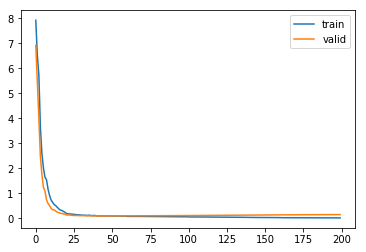

In [17]:
plt.plot(losses)
plt.legend(['train', 'valid'])

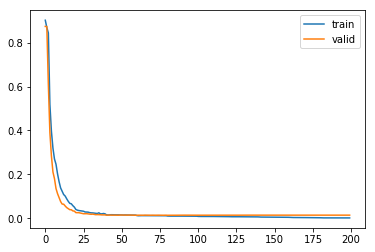

In [18]:
plt.plot(missclass)
plt.legend(['train', 'valid'])

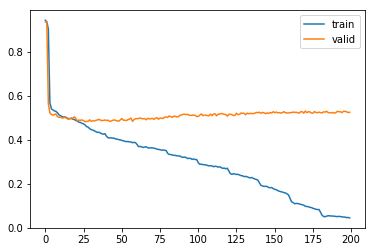

In [19]:
plt.plot(missclass_next)
plt.legend(['train', 'valid'])